## Takes an image of a table, detects edges and values

In [1]:
# Imports

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sample = 'Data/Fixed_vertical/yr_2020.png'
img = cv2.imread(sample,0)

### Global threshholding

In [2]:
thresh,img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
img_bin = 255-img_bin
plotting = plt.imshow(img_bin,cmap='gray')
plt.title("Inverted Image with global thresh holding")
plt.show()

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

#### Otsu thresholding

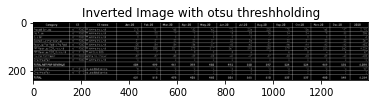

In [3]:
img_bin1 = 255-img
thresh1,img_bin1_otsu = cv2.threshold(img_bin1,128,255,cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin1_otsu,cmap='gray')
plt.title("Inverted Image with otsu threshholding")
plt.show()

If both cv2.THRESH_BINARY and cv2.THRESH_OTSU are passed in the fourth parameter, the function performs both global and otsu thresholding.

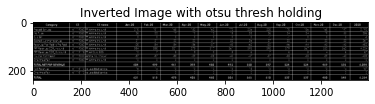

In [4]:
img_bin2 = 255-img
thresh1,img_bin_otsu = cv2.threshold(img_bin2,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

Morphological operations are performed on images based on their shapes. It takes the image and a structuring element or kernel.

cv2.getStructuringElement() : Here the shape and size of the kernel can be passed as parameters and accordingly a matrix is generated.

This is the format of use, as this may be tricky to remember:

    The first argument specifies the shape of the kernel that you want, can be rectangular, circular or even elliptical.
    The second argument is tuple denoting the shape of the required kernel, the width and height.

In [5]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

In [6]:
np.array(img).shape

(239, 1395)

### Extracting vertical lines

In [7]:
import numpy
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//150))
eroded_image = cv2.erode(img_bin2, vertical_kernel, iterations=5)

In [9]:
vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=5)

### Extracting horizontal Lines

In [10]:
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))
image_2 = cv2.erode(img_bin, hor_kernel, iterations=5)

horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=5)

In [11]:
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

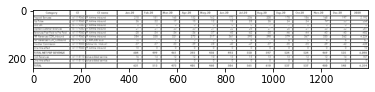

In [12]:
thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))
plotting = plt.imshow(b_image,cmap='gray')
plt.show()

In [13]:
import pytesseract

### Contours

In [14]:
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### Bounding Boxes

In [16]:
boundingBoxes = [cv2.boundingRect(c) for c in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda x:x[1][1]))

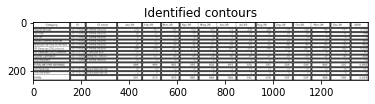

In [17]:
boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        boxes.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.title("Identified contours")
plt.show()

In [18]:
rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
print(mean)
columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
    if(boxes[i][1]<=previous[1]+mean/2):
        columns.append(boxes[i])
        previous=boxes[i]
        if(i==len(boxes)-1):
            rows.append(columns)
    else:
        rows.append(columns)
        columns=[]
        previous = boxes[i]
        columns.append(boxes[i])
print("Rows")
for row in rows:
    print(row)

13.362385321100918
Rows
[[1324, 0, 71, 22], [1240, 0, 80, 22], [1084, 0, 152, 22], [1006, 0, 74, 22], [929, 0, 73, 22], [612, 0, 313, 22], [535, 0, 73, 22], [456, 0, 75, 22], [352, 0, 100, 22], [221, 0, 127, 22], [156, 0, 61, 22], [0, 0, 152, 22]]
[[1324, 26, 71, 13], [1240, 26, 80, 13], [1161, 26, 75, 13], [1084, 26, 73, 12], [1006, 26, 74, 12], [929, 26, 73, 12], [849, 26, 76, 12], [769, 26, 76, 12], [691, 26, 74, 12], [612, 26, 75, 12], [535, 26, 73, 12], [456, 26, 75, 12], [352, 26, 100, 12], [221, 26, 127, 12], [156, 26, 61, 12], [0, 26, 152, 12]]
[[1161, 42, 75, 13], [1084, 42, 73, 13], [1006, 42, 74, 13], [929, 42, 73, 13], [849, 42, 76, 13], [769, 42, 76, 13], [691, 42, 74, 13], [612, 42, 75, 13], [535, 42, 73, 13], [456, 42, 75, 13], [352, 42, 100, 13], [221, 42, 127, 13], [156, 42, 61, 13], [0, 42, 152, 13], [1324, 43, 71, 12], [1240, 43, 80, 12]]
[[1324, 59, 71, 11], [1240, 59, 80, 11], [1161, 59, 75, 11], [1084, 59, 73, 11], [1006, 59, 74, 11], [929, 59, 73, 11], [849, 59, 

#### Lets get the total cells in each row :


In [19]:
total_cells=0
for i in range(len(row)):
    if len(row[i]) > total_cells:
        total_cells = len(row[i])
print(total_cells)

4


In [20]:
center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(center)
center=np.array(center)
center.sort()
print(center)

IndexError: list index out of range

In [1]:
from ExtractTable import ExtractTable
et_sess = ExtractTable(api_key=YOUR_API_KEY)        # Replace your VALID API Key here
print(et_sess.check_usage())        # Checks the API Key validity as well as shows associated plan usage 
table_data = et_sess.process_file(filepath=Location_of_Image_with_Tables, output_format="df")

# To process PDF, make use of pages ("1", "1,3-4", "all") params in the read_pdf function
table_data = et_sess.process_file(filepath=Location_of_PDF_with_Tables, output_format="df", pages="all")

NameError: name 'YOUR_API_KEY' is not defined

In [36]:
#Setting matplot figure size
plt.rcParams['figure.figsize'] = [15, 8]

In [37]:
# loading image form directory
img = cv2.imread('Data/Fixed_vertical/yr_2020.png',0)

In [38]:
img.shape

(239, 1395)

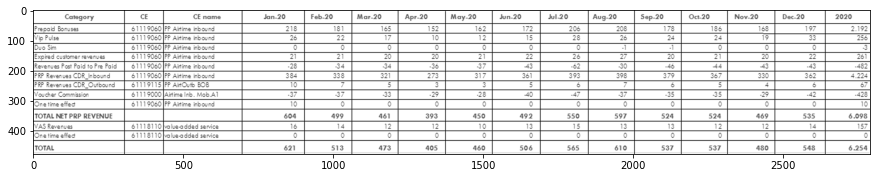

In [39]:
# showing image
imgplot = plt.imshow(cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [40]:
# for adding border to an image
img1= cv2.copyMakeBorder(img,50,50,50,50,cv2.BORDER_CONSTANT,value=[255,255])

In [41]:
img123 = img1.copy()

In [42]:
# Thresholding the image
(thresh, th3) = cv2.threshold(img1, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)

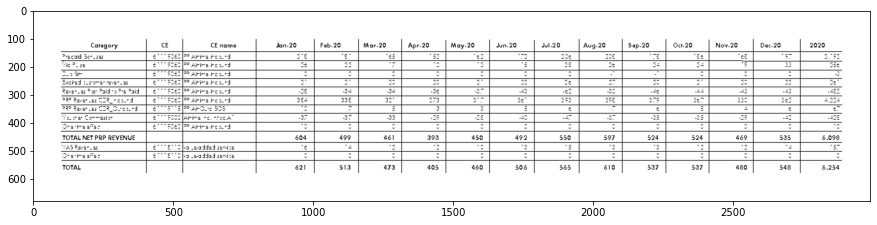

In [43]:
imgplot = plt.imshow(cv2.resize(th3, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [44]:
# to flip image pixel values
th3 = 255-th3

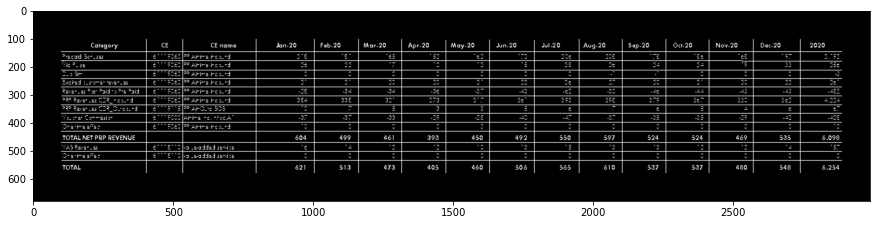

In [45]:
imgplot = plt.imshow(cv2.resize(th3, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [46]:
# initialize kernels for table boundaries detections
if(th3.shape[0]<1000):
    ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
    hor = np.array([[1,1,1,1,1,1]])
    
else:
    ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
    hor = np.array([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

In [47]:
# to detect vertical lines of table borders
img_temp1 = cv2.erode(th3, ver, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, ver, iterations=3)

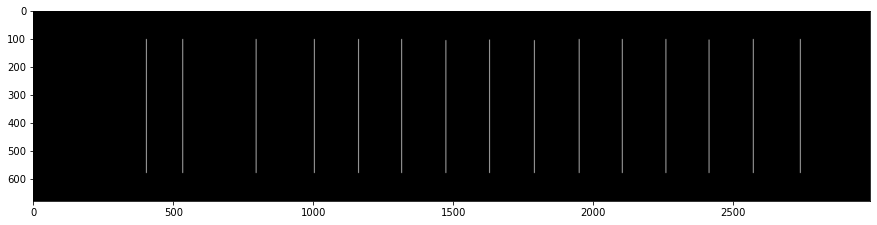

In [48]:
imgplot = plt.imshow(cv2.resize(verticle_lines_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [49]:
# to detect horizontal lines of table borders
img_hor = cv2.erode(th3, hor, iterations=3)
hor_lines_img = cv2.dilate(img_hor, hor, iterations=4)

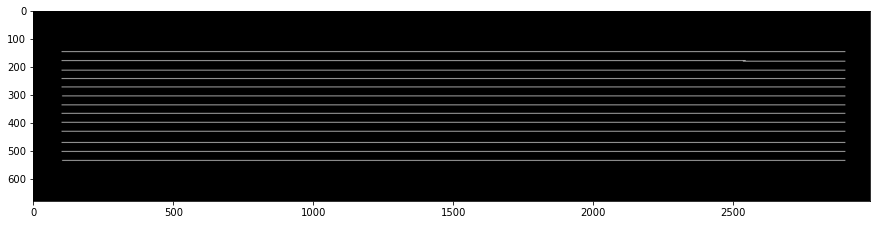

In [50]:
imgplot = plt.imshow(cv2.resize(hor_lines_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [51]:
# adding horizontal and vertical lines
hor_ver = cv2.add(hor_lines_img,verticle_lines_img)

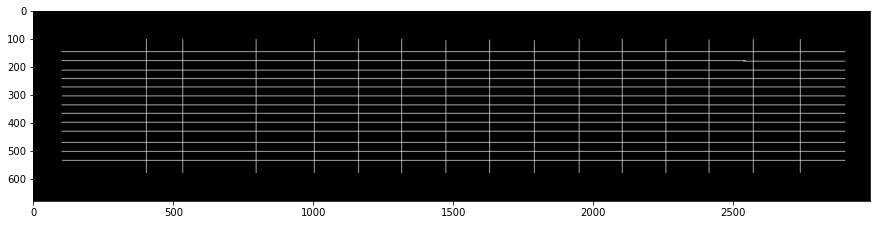

In [52]:
imgplot = plt.imshow(cv2.resize(hor_ver, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [53]:
hor_ver = 255-hor_ver

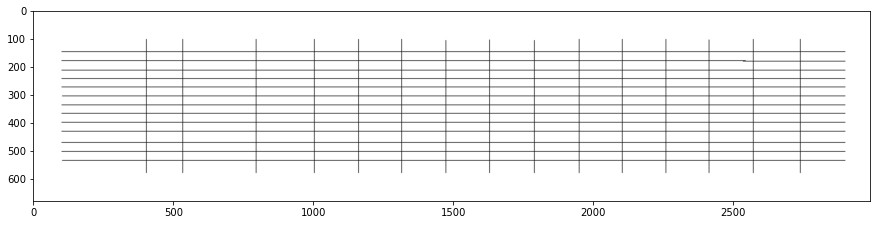

In [54]:
imgplot = plt.imshow(cv2.resize(hor_ver, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [55]:
# subtracting table borders from image
temp = cv2.subtract(th3,hor_ver)

In [56]:
temp = 255-temp

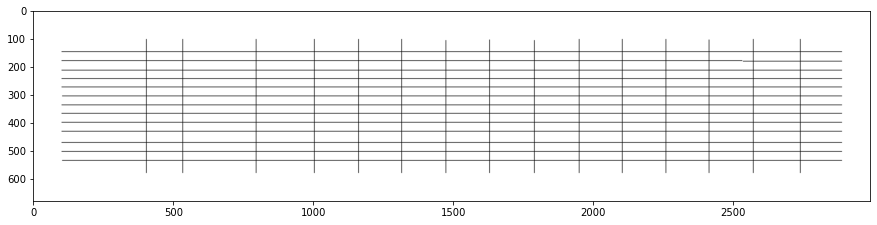

In [57]:
imgplot = plt.imshow(cv2.resize(temp, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [58]:
#Doing xor operation for erasing table boundaries
tt = cv2.bitwise_xor(img1,temp)

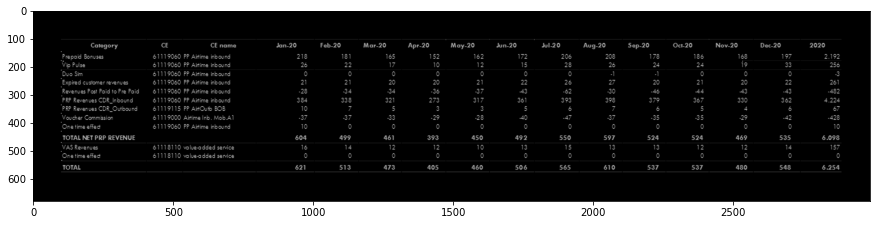

In [59]:
imgplot = plt.imshow(cv2.resize(tt, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [60]:
iii = cv2.bitwise_not(tt)

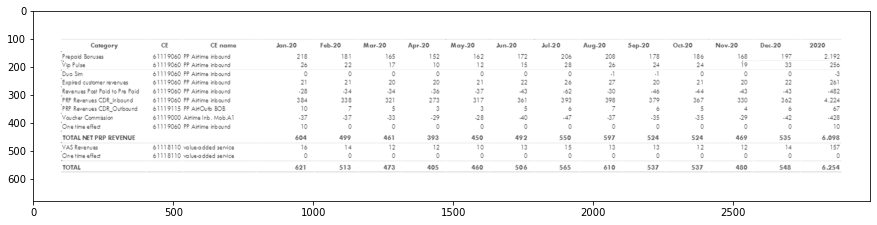

In [61]:
imgplot = plt.imshow(cv2.resize(iii, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [62]:
tt1=iii.copy()

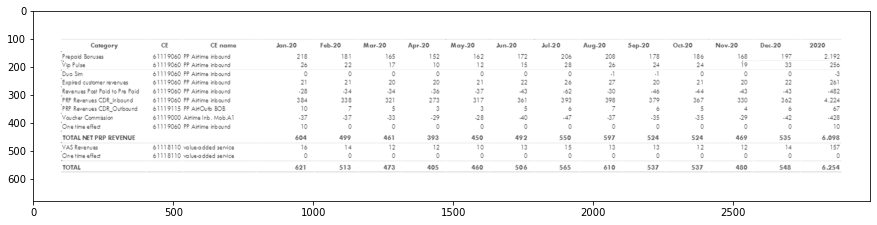

In [63]:
imgplot = plt.imshow(cv2.resize(tt1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [64]:
#kernel initialization
ver1 = np.array([[1,1],
               [1,1],
               [1,1],
               [1,1],
               [1,1],
               [1,1],
               [1,1],
               [1,1],
               [1,1]])

In [65]:
hor1 = np.array([[1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1]])

In [66]:
#morphological operation
temp1 = cv2.erode(tt1, ver1, iterations=1)
verticle_lines_img1 = cv2.dilate(temp1, ver1, iterations=1)

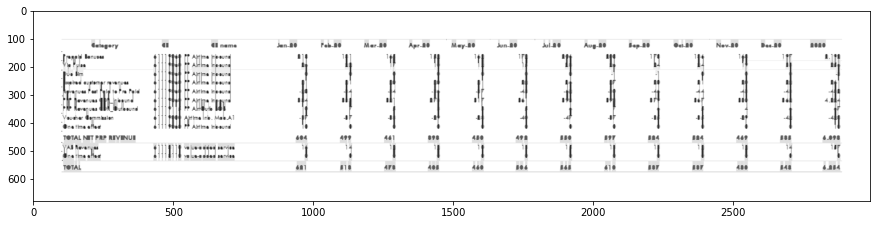

In [67]:
imgplot = plt.imshow(cv2.resize(verticle_lines_img1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [68]:
temp12 = cv2.erode(tt1, hor1, iterations=1)
hor_lines_img2 = cv2.dilate(temp12, hor1, iterations=1)

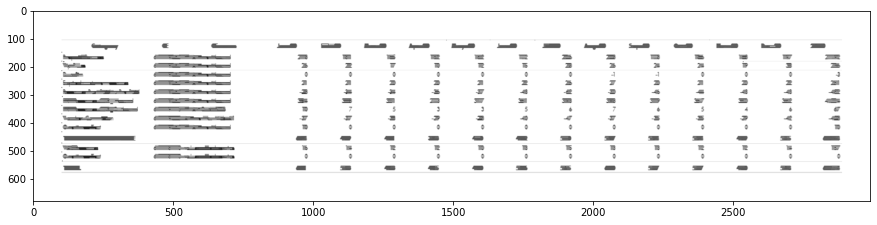

In [69]:
imgplot = plt.imshow(cv2.resize(hor_lines_img2, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [70]:
# doing or operation for detecting only text part and removing rest all
hor_ver = cv2.add(hor_lines_img2,verticle_lines_img1)

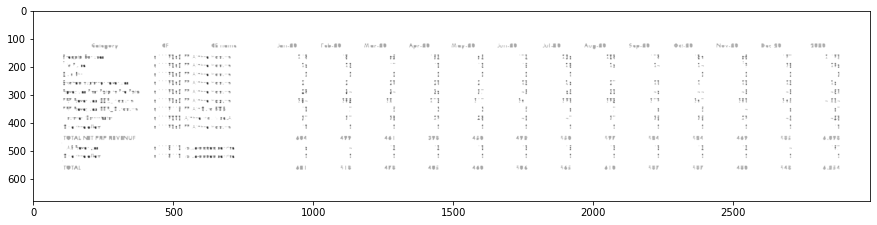

In [71]:
imgplot = plt.imshow(cv2.resize(hor_ver, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [72]:
dim1 = (hor_ver.shape[1],hor_ver.shape[0])

In [73]:
dim = (hor_ver.shape[1]*2,hor_ver.shape[0]*2)

In [74]:
# resizing image to its double size to increase the text size
resized = cv2.resize(hor_ver, dim, interpolation = cv2.INTER_AREA)

In [75]:
#bitwise not operation for fliping the pixel values so as to apply morphological operation such as dilation and erode
want = cv2.bitwise_not(resized)

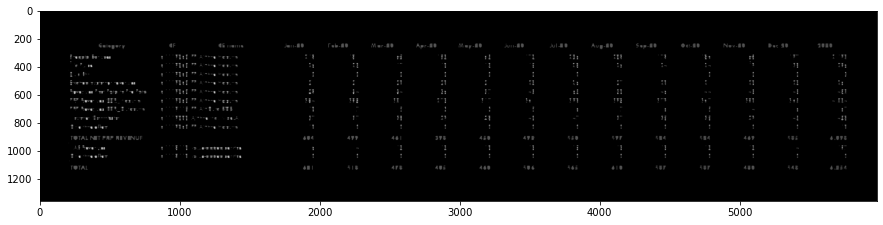

In [76]:
imgplot = plt.imshow(cv2.resize(want, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [77]:
if(want.shape[0]<1000):
    kernel1 = np.array([[1,1,1]])
    kernel2 = np.array([[1,1],
                        [1,1]])
    kernel3 = np.array([[1,0,1],[0,1,0],
                       [1,0,1]])
else:
    kernel1 = np.array([[1,1,1,1,1,1]])
    kernel2 = np.array([[1,1,1,1,1],
                        [1,1,1,1,1],
                        [1,1,1,1,1],
                        [1,1,1,1,1]])

In [78]:
tt1 = cv2.dilate(want,kernel1,iterations=14)

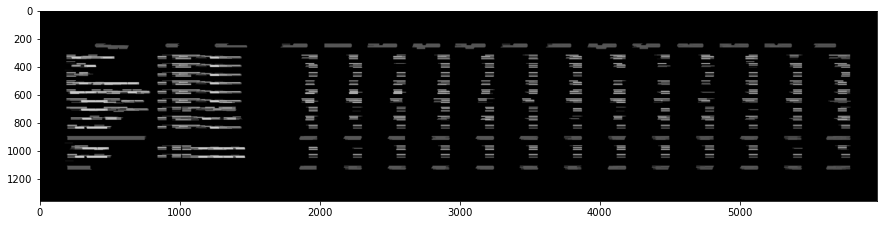

In [79]:
imgplot = plt.imshow(cv2.resize(tt1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC),cmap='gray')
plt.show()

In [80]:
# getting image back to its original size
resized1 = cv2.resize(tt1, dim1, interpolation = cv2.INTER_AREA)

In [87]:
# Find contours for image, which will detect all the boxes
im21, contours1 = cv2.findContours(resized1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [92]:
#function to sort contours by its x-axis (top to bottom)
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
 
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
 
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
 
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))
 
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [91]:
#sorting contours by calling fuction
(cnts, boundingBoxes) = sort_contours(contours1, method="top-to-bottom")

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:874: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::pointSetBoundingRect'
